In [1]:
import xarray as xr
import geopandas as gpd
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Parameters Required

- [x] run_cell - Mask, whether to run cell (1 = Yes; 0 = No)
- [x] gridcell - Grid cell ID
- [x] lat
- [x] lon
- [x] infilt - Variable infiltration curve parameter (binfilt)
- [x] Ds - Fraction of Dsmax where non-linear baseflow begins
- [x] Ds_max - Maximum velocity of baseflow
- [x] Ws - Fraction of maximum soil moisture where non-linear baseflow occurs
- [x] c - Exponent used in baseflow curve, normally set to 2
- [x] expt - Exponent n (=3+2/lambda) in Campbell's eqn for hydraulic conductivity, HBH 5.6 (where lambda = soil pore size distribution parameter). Values should be > 3.0.
- [x] Ksat
- [x] phi_s
- [x] init_moist - Initial layer moisture content
- [x] elev(lat, lon) - Average elevation of grid cell
- [x] depth(nlayer, lat, lon) - Thickness of each soil moisture layer
- [x] avg_T(lat, lon) - Average soil temperature, used as the bottom boundary for soil heat flux solutions
- [x] dp(lat, lon) - Soil thermal damping depth (depth at which soil temperature remains constant through the year, ~4 m)
- [x] bubble(nlayer, lat, lon) - Bubbling pressure of soil. Values should be > 0.0
- [x] quartz(nlayer, lat, lon) - Quartz content of soil
- [x] bulk_density(nlayer, lat, lon) - Bulk density of soil layer
- [x] soil_density(nlayer, lat, lon) - Soil particle density, normally 2685 kg/m3
- [x] off_gmt(lat, lon) - Time zone offset from GMT. This parameter determines how VIC interprets sub-daily time steps relative to the model start date and time.
- [x] Wcr_FRACT(nlayer, lat, lon) - Fractional soil moisture content at the critical point (~70%% of field capacity) (fraction of maximum moisture)
- [x] Wpwp_FRACT(nlayer, lat, lon) - Fractional soil moisture content at the wilting point (fraction of maximum moisture)
- [x] rough(lat, lon) - Surface roughness of bare soil
- [x] snow_rough(lat, lon) - Surface roughness of snowpack
- [x] annual_prec(lat, lon) - Average annual precipitation.
- [x] resid_moist(nlayer, lat, lon) - Soil moisture layer residual moisture.
- [x] fs_active(lat, lon) - If set to 1, then frozen soil algorithm is activated for the grid cell. A 0 indicates that frozen soils are not computed even if soil temperatures fall below 0C.
- [ ] snow_band(snow_band) - snow band - Grid cell number (should match numbers assigned in soil parameter file)
- [ ] AreaFract(snow_band, lat, lon) - Fraction of grid cell covered by each elevation band. Sum of the fractions must equal 1." ;
- [ ] elevation(snow_band, lat, lon) - Mean (or median) elevation of elevation band. This is used to compute the change in air temperature from the grid cell mean elevation.
- [ ] Pfactor(snow_band, lat, lon) - Fraction of cell precipitation thatfalls on each elevation band. Total must equal 1. To ignore effects of elevation on precipitation, set these fractions equal to the area fractions.
- [x] veg_class(veg_class) - Vegetation Class
- [x] veg_descr(veg_class) - Vegetation Class Description
- [x] root_zone(root_zone)- root zone
- [x] month(month) - month of year
- [x] Nveg(lat, lon) - Number of vegetation tiles in the grid cell
- [x] Cv(veg_class, lat, lon) - Fraction of grid cell covered by vegetation tile
- [x] root_depth(veg_class, root_zone, lat, lon) - Root zone thickness (sum of depths is total depth of root penetration)
- [x] root_fract(veg_class, root_zone, lat, lon) - Fraction of root in the current root zone
- [x] LAI(veg_class, month, lat, lon) - Leaf Area Index, one per month
- [x] overstory(veg_class, lat, lon) - Flag to indicate whether or not the current vegetation type has an overstory (1 for overstory present [e.g. trees], 0 for overstory not present [e.g. grass])
- [x] rarc(veg_class, lat, lon) - Architectural resistance of vegetation type (~2 s/m)
- [x] rmin(veg_class, lat, lon) - Minimum stomatal resistance of vegetation type (~100 s/m)
- [x] wind_h(veg_class, lat, lon) - Height at which wind speed is measured.
- [x] RGL(veg_class, lat, lon) - Minimum incoming shortwave radiation at which there will be transpiration. For trees this is about 30 W/m^2, for crops about 100 W/m^2.
- [x] rad_atten(veg_class, lat, lon) - Radiation attenuation factor. Normally set to 0.5, though may need to be adjusted for high latitudes.
- [x] wind_atten(veg_class, lat, lon) - Wind speed attenuation through the overstory. The default value has been 0.5.
- [x] trunk_ratio(veg_class, lat, lon) - Ratio of total tree height that is trunk (no branches). The default value has been 0.2.
- [x] albedo(veg_class, month, lat, lon) - Shortwave albedo for vegetation type
- [x] veg_rough(veg_class, month, lat, lon) - Vegetation roughness length (typically 0.123 * vegetation height)
- [x] displacement(veg_class, month, lat, lon) - Vegetation displacement height (typically 0.67 * vegetation height)" ;

In [2]:
params = gpd.read_file("../backend/data/ancillary/PARAMS.shp")
params.head()

,id,lat,lon,area_m2,INFILT,Ds,Ds_MAX,Ws,C,EXPT_1,...,WcrFT2,WpFT1,WpFT2,Z0_SOIL,Z0_SNOW,PRCP,RESM1,RESM2,FS_ACTV,geometry
0,3891.0,33.781,94.469,40272699.36,0.1,0.3,11.774,1.0,2,12.68,...,0.525,0.225,0.225,0.001,0.0005,580,0.041,0.041,1,"POLYGON ((94.43750 33.81250, 94.50000 33.81250..."
1,4280.0,33.781,94.531,40267909.61,0.1,0.3,11.774,1.0,2,12.68,...,0.525,0.225,0.225,0.001,0.0005,580,0.041,0.041,1,"POLYGON ((94.50000 33.81250, 94.56250 33.81250..."
2,4669.0,33.781,94.594,40263186.97,0.1,0.3,11.774,1.0,2,12.68,...,0.525,0.225,0.225,0.001,0.0005,576,0.041,0.041,1,"POLYGON ((94.56250 33.81250, 94.62500 33.81250..."
3,5058.0,33.781,94.656,40258531.41,0.1,0.3,11.774,1.0,2,12.68,...,0.525,0.225,0.225,0.001,0.0005,576,0.041,0.041,1,"POLYGON ((94.62500 33.81250, 94.68750 33.81250..."
4,3892.0,33.719,94.469,40301775.69,0.1,0.3,5.716,1.0,2,13.60,...,0.674,0.326,0.326,0.001,0.0005,583,0.027,0.027,1,"POLYGON ((94.43750 33.75000, 94.50000 33.75000..."


In [3]:
# params.to_csv("../backend/data/ancillary/PARAMS.csv")

In [4]:
params.columns

## Some columns only depend on lat lon, while others may also depend on n_layer. Need to separate them

Index(['id', 'lat', 'lon', 'area_m2', 'INFILT', 'Ds', 'Ds_MAX', 'Ws', 'C',
       'EXPT_1', 'EXPT_2', 'Ksat_1', 'Ksat_2', 'PHI_1', 'PHI_2', 'MOIST_1',
       'MOIST_2', 'ELEV', 'DEPTH_1', 'DEPTH_2', 'AVG_T', 'DP', 'BUBLE1',
       'BUBLE2', 'QUARZ1', 'QUARZ2', 'BULKDN1', 'BULKDN2', 'PARTDN1',
       'PARTDN2', 'OFF_GMT', 'WcrFT1', 'WcrFT2', 'WpFT1', 'WpFT2', 'Z0_SOIL',
       'Z0_SNOW', 'PRCP', 'RESM1', 'RESM2', 'FS_ACTV', 'geometry'],
      dtype='object')

In [5]:
# columns depending on only lat-lon
subset = params[['lat', 'lon', 'id', 'INFILT', 'Ds', 'Ds_MAX', 'Ws', 'C', 'AVG_T', 'DP', 'OFF_GMT', 'Z0_SOIL', 'Z0_SNOW', 'PRCP', 'FS_ACTV']].set_index(['lat', 'lon'])
subset = subset.rename({
    'id': 'gridcell',
    'INFILT': 'infilt',
    'Ds': 'Ds',
    'Ds_MAX': 'Dsmax',
    'Ws': 'Ws',
    'C': 'c',
    'AVG_T': 'avg_T',
    'DP': 'dp',
    'OFF_GMT': 'off_gmt',
    'Z0_SOIL': 'rough',
    'Z0_SNOW': 'snow_rough',
    'PRCP': 'annual_prec',
    'FS_ACTV': 'fs_active'
}, axis=1)
subset['run_cell'] = 1

param_ds = subset.to_xarray()

In [6]:
param_ds

<xarray.Dataset>
Dimensions:      (lat: 388, lon: 237)
Coordinates:
  * lat          (lat) float64 9.594 9.656 9.719 9.781 ... 33.66 33.72 33.78
  * lon          (lon) float64 93.91 93.97 94.03 94.09 ... 108.5 108.6 108.7
Data variables: (12/14)
    gridcell     (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    infilt       (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    Ds           (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    Dsmax        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    Ws           (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    c            (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    ...           ...
    off_gmt      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    rough        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    snow_rough   (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    annual_prec  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    fs_active    (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    run_cell     (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan

In [7]:
# Elevation
run_cell = rio.open("../backend/data/ancillary/MASK.tif").read(1, masked=True).astype(np.int32).filled(0)

run_cell_da = xr.DataArray(np.flip(run_cell, axis=0), coords=[param_ds.coords['lat'], param_ds.coords['lon']], dims=['lat', 'lon'])
run_cell_da

param_ds['run_cell'] = run_cell_da
param_ds

<xarray.Dataset>
Dimensions:      (lat: 388, lon: 237)
Coordinates:
  * lat          (lat) float64 9.594 9.656 9.719 9.781 ... 33.66 33.72 33.78
  * lon          (lon) float64 93.91 93.97 94.03 94.09 ... 108.5 108.6 108.7
Data variables: (12/14)
    gridcell     (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    infilt       (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    Ds           (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    Dsmax        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    Ws           (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    c            (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    ...           ...
    off_gmt      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    rough        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    snow_rough   (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    annual_prec  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    fs_active    (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    run_cell     (lat, lon) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0

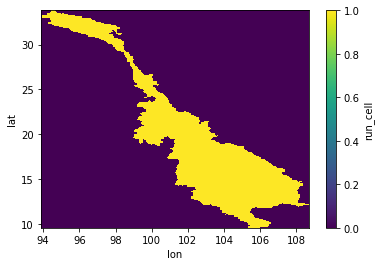

In [8]:
param_ds.run_cell.plot()

In [9]:
# Elevation
elev = rio.open("../backend/data/ancillary/SRTM.tif").read(1, masked=True).astype(np.float32).filled(np.nan)

elev_da = xr.DataArray(elev, coords=[param_ds.coords['lat'], param_ds.coords['lon']], dims=['lat', 'lon'])
elev_da

param_ds['elev'] = elev_da
param_ds

<xarray.Dataset>
Dimensions:      (lat: 388, lon: 237)
Coordinates:
  * lat          (lat) float64 9.594 9.656 9.719 9.781 ... 33.66 33.72 33.78
  * lon          (lon) float64 93.91 93.97 94.03 94.09 ... 108.5 108.6 108.7
Data variables: (12/15)
    gridcell     (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    infilt       (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    Ds           (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    Dsmax        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    Ws           (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    c            (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    ...           ...
    rough        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    snow_rough   (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    annual_prec  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    fs_active    (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    run_cell     (lat, lon) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    elev         (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan

In [10]:
# Data vars dependent on soil layer as well

soil_1_params = params[['lat', 'lon', 'EXPT_1', 'Ksat_1', 'PHI_1', 'MOIST_1', 'DEPTH_1', 'BUBLE1', 'QUARZ1', 'BULKDN1', 'PARTDN1', 'WcrFT1', 'WpFT1', 'RESM1']]
soil_1_params['nlayer'] = 1
# soil_1_params = soil_1_params.set_index(['nlayer', 'lat', 'lon'])
soil_1_params = soil_1_params.rename({
    'EXPT_1': 'expt',
    'Ksat_1': 'Ksat',
    'PHI_1': 'phi_s',
    'MOIST_1': 'init_moist',
    'DEPTH_1': 'depth',
    'BUBLE1': 'bubble',
    'QUARZ1': 'quartz',
    'BULKDN1': 'bulk_density',
    'PARTDN1': 'soil_density',
    'WcrFT1': 'Wcr_FRACT',
    'WpFT1': 'Wpwp_FRACT',
    'RESM1': 'resid_moist'
}, axis=1)

soil_2_params = params[['lat', 'lon', 'EXPT_2', 'Ksat_2', 'PHI_2', 'MOIST_2', 'DEPTH_2', 'BUBLE2', 'QUARZ2', 'BULKDN2', 'PARTDN2', 'WcrFT2', 'WpFT2', 'RESM2']]
soil_2_params['nlayer'] = 2
# soil_1_params = soil_1_params.set_index(['nlayer', 'lat', 'lon'])
soil_2_params = soil_2_params.rename({
    'EXPT_2': 'expt',
    'Ksat_2': 'Ksat',
    'PHI_2': 'phi_s',
    'MOIST_2': 'init_moist',
    'DEPTH_2': 'depth',
    'BUBLE2': 'bubble',
    'QUARZ2': 'quartz',
    'BULKDN2': 'bulk_density',
    'PARTDN2': 'soil_density',
    'WcrFT2': 'Wcr_FRACT',
    'WpFT2': 'Wpwp_FRACT',
    'RESM2': 'resid_moist'
}, axis=1)

soil_params = pd.concat([soil_1_params, soil_2_params]).set_index(['nlayer', 'lat', 'lon']).to_xarray()
param_ds = param_ds.merge(soil_params, join='exact')

/houston2/pritam/rat_mekong_v3/.condaenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/houston2/pritam/rat_mekong_v3/.condaenv/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Now for the vegetation parameters

In [11]:
# parsing veg param file into a dataframe, later will join with soil parameter file using gridcell-id
param_fp = "../backend/data/ancillary/shahryar_params/veg_params.txt"
with open(param_fp, 'r') as f:
    raw_data = f.readlines()

In [12]:
data = {
    'gridcell': [],
    'Nveg': [],
    'veg_class': [],
    'Cv': [],
    'root_depth_1': [],
    'root_fract_1': [],
    'root_depth_2': [],
    'root_fract_2': [],
    'root_depth_3': [],
    'root_fract_3': []
}

LAIs = []

while len(raw_data) > 0:
    a = raw_data.pop(0).strip().split()
    b = raw_data.pop(0).strip().split()
    c = raw_data.pop(0).strip()
    
    data['gridcell'].append(float(a[0]))
    data['Nveg'].append(float(a[1]))
    data['veg_class'].append(float(b[0]))
    data['Cv'].append(float(b[1]))
    data['root_depth_1'].append(float(b[2]))
    data['root_fract_1'].append(float(b[3]))
    data['root_depth_2'].append(float(b[4]))
    data['root_fract_2'].append(float(b[5]))
    data['root_depth_3'].append(float(b[6]))
    data['root_fract_3'].append(float(b[7]))
    
    LAIs.append([float(x) for x in c.split()])

In [13]:
LAI = pd.DataFrame(LAIs, columns=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])

In [14]:
veg_params = pd.DataFrame(data)

In [15]:
merged_vegparams = pd.concat([veg_params, LAI], axis=1)

In [16]:
merged_vegparams.head()

,gridcell,Nveg,veg_class,Cv,root_depth_1,root_fract_1,root_depth_2,root_fract_2,root_depth_3,root_fract_3,...,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
0,1.0,1.0,8.0,1.0,0.1,0.1,1.0,0.65,0.5,0.25,...,0.181,0.159,0.217,0.427,0.943,0.996,0.581,0.248,0.130,0.146
1,2.0,1.0,7.0,1.0,0.1,0.1,1.0,0.65,0.5,0.25,...,0.161,0.185,0.209,0.463,1.006,1.037,0.602,0.226,0.118,0.144
2,3.0,1.0,7.0,1.0,0.1,0.1,1.0,0.65,0.5,0.25,...,0.187,0.201,0.228,0.506,1.083,1.116,0.598,0.250,0.159,0.156
3,4.0,1.0,7.0,1.0,0.1,0.1,1.0,0.65,0.5,0.25,...,0.175,0.171,0.215,0.465,0.992,1.008,0.563,0.232,0.150,0.142
4,5.0,1.0,8.0,1.0,0.1,0.1,1.0,0.65,0.5,0.25,...,0.171,0.187,0.220,0.474,1.022,1.067,0.585,0.226,0.130,0.144


In [17]:
# Insert Lat-Long information from soil param file
temp_soil = pd.read_csv("../backend/data/ancillary/shahryar_params/soil_mekong.tsv", sep='\t', dtype=np.float32)[['GRID', 'LAT', 'LNG']].rename({'GRID': 'gridcell'}, axis=1)
merged_vegparams = temp_soil.merge(merged_vegparams, left_on='gridcell', right_on='gridcell')
merged_vegparams

,gridcell,LAT,LNG,Nveg,veg_class,Cv,root_depth_1,root_fract_1,root_depth_2,root_fract_2,...,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
0,1.0,33.799999,94.500000,1.0,8.0,1.0,0.1,0.1,1.0,0.65,...,0.181,0.159,0.217,0.427,0.943,0.996,0.581,0.248,0.130,0.146
1,2.0,33.799999,94.599998,1.0,7.0,1.0,0.1,0.1,1.0,0.65,...,0.161,0.185,0.209,0.463,1.006,1.037,0.602,0.226,0.118,0.144
2,3.0,33.700001,94.400002,1.0,7.0,1.0,0.1,0.1,1.0,0.65,...,0.187,0.201,0.228,0.506,1.083,1.116,0.598,0.250,0.159,0.156
3,4.0,33.700001,94.500000,1.0,7.0,1.0,0.1,0.1,1.0,0.65,...,0.175,0.171,0.215,0.465,0.992,1.008,0.563,0.232,0.150,0.142
4,5.0,33.700001,94.599998,1.0,8.0,1.0,0.1,0.1,1.0,0.65,...,0.171,0.187,0.220,0.474,1.022,1.067,0.585,0.226,0.130,0.144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6761,8149.0,9.600000,105.400002,1.0,2.0,1.0,0.1,0.1,1.0,0.55,...,0.955,0.994,1.319,1.177,1.215,1.301,1.055,1.528,2.528,2.341
6762,8150.0,9.600000,105.500000,1.0,3.0,1.0,0.1,0.1,1.0,0.55,...,0.665,0.722,1.272,1.175,1.175,1.327,0.951,0.829,1.640,2.065
6763,8151.0,9.600000,105.599998,1.0,3.0,1.0,0.1,0.1,1.0,0.55,...,0.780,0.864,1.577,1.783,1.238,0.884,0.585,0.449,0.437,1.132
6764,8152.0,9.600000,105.699997,1.0,3.0,1.0,0.1,0.1,1.0,0.55,...,1.104,1.303,1.774,2.112,1.502,1.059,0.919,0.480,0.913,1.140


In [18]:
# Join with vegetation library
veg_lib = pd.read_csv("../backend/data/ancillary/shahryar_params/library_mekong_vegetation.tsv", sep='\t')
merged_vegparams = merged_vegparams.merge(veg_lib, right_on='Class', left_on='veg_class')

In [19]:
merged_vegparams.columns

Index(['gridcell', 'LAT', 'LNG', 'Nveg', 'veg_class', 'Cv', 'root_depth_1',
       'root_fract_1', 'root_depth_2', 'root_fract_2', 'root_depth_3',
       'root_fract_3', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug',
       'sep', 'oct', 'nov', 'dec', 'Class', 'OvrStry', 'Rarc', 'Rmin',
       'JAN-LAI', 'FEB-LAI', 'MAR-LAI', 'APR-LAI', 'MAY-LAI', 'JUN-LAI',
       'JUL-LAI', 'AUG-LAI', 'SEP-LAI', 'OCT-LAI', 'NOV-LAI', 'DEC-LAI',
       'JAN-ALB', 'FEB_ALB', 'MAR-ALB', 'APR-ALB', 'MAY-ALB', 'JUN-ALB',
       'JUL-ALB', 'AUG-ALB', 'SEP-ALB', 'OCT-ALB', 'NOV-ALB', 'DEC-ALB',
       'JAN-ROU', 'FEB-ROU', 'MAR-ROU', 'APR-ROU', 'MAY-ROU', 'JUN-ROU',
       'JUL-ROU', 'AUG-ROU', 'SEP-ROU', 'OCT-ROU', 'NOV-ROU', 'DEC-ROU',
       'JAN-DIS', 'FEB-DIS', 'MAR-DIS', 'APR-DIS', 'MAY-DIS', 'JUN-DIS',
       'JUL-DIS', 'AUG-DIS', 'SEP-DIS', 'OCT-DIS', 'NOV-DIS', 'DEC-DIS',
       'WIND_H', 'RGL', 'rad_atten', 'wind_atten', 'truck_ratio', 'COMMENT'],
      dtype='object')

In [20]:
# # Save as CSV in the ancillary data directory
# merged_vegparams.to_csv("../backend/data/ancillary/VEG.csv")

In [21]:
merged_vegparams

,gridcell,LAT,LNG,Nveg,veg_class,Cv,root_depth_1,root_fract_1,root_depth_2,root_fract_2,...,SEP-DIS,OCT-DIS,NOV-DIS,DEC-DIS,WIND_H,RGL,rad_atten,wind_atten,truck_ratio,COMMENT
0,1.0,33.799999,94.500000,1.0,8.0,1.0,0.1,0.1,1.0,0.65,...,0.201,0.201,0.201,0.20,2.3,60,0.5,0.5,0.2,SHRUBLAND
1,5.0,33.700001,94.599998,1.0,8.0,1.0,0.1,0.1,1.0,0.65,...,0.201,0.201,0.201,0.20,2.3,60,0.5,0.5,0.2,SHRUBLAND
2,27.0,33.400002,94.900002,1.0,8.0,1.0,0.1,0.1,1.0,0.65,...,0.201,0.201,0.201,0.20,2.3,60,0.5,0.5,0.2,SHRUBLAND
3,42.0,33.299999,95.000000,1.0,8.0,1.0,0.1,0.1,1.0,0.65,...,0.201,0.201,0.201,0.20,2.3,60,0.5,0.5,0.2,SHRUBLAND
4,44.0,33.299999,95.199997,1.0,8.0,1.0,0.1,0.1,1.0,0.65,...,0.201,0.201,0.201,0.20,2.3,60,0.5,0.5,0.2,SHRUBLAND
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6761,6026.0,15.000000,102.099998,1.0,1.0,1.0,0.1,0.1,1.0,0.55,...,0.469,0.469,0.469,0.47,2.7,100,0.5,0.5,0.2,"Urban, Class 2 Data Used"
6762,6036.0,15.000000,103.099998,1.0,1.0,1.0,0.1,0.1,1.0,0.55,...,0.469,0.469,0.469,0.47,2.7,100,0.5,0.5,0.2,"Urban, Class 2 Data Used"
6763,6106.0,14.900000,103.500000,1.0,1.0,1.0,0.1,0.1,1.0,0.55,...,0.469,0.469,0.469,0.47,2.7,100,0.5,0.5,0.2,"Urban, Class 2 Data Used"
6764,6854.0,13.700000,102.500000,1.0,1.0,1.0,0.1,0.1,1.0,0.55,...,0.469,0.469,0.469,0.47,2.7,100,0.5,0.5,0.2,"Urban, Class 2 Data Used"


In [22]:
## Now that we have Soil_veg_params as one file, use that to generate the the rest of the DataSet
params = pd.read_csv("../backend/data/ancillary/SOIL_VEG_PARAMS.csv").set_index(['lat', 'lon'])
params

gridcel      area_m2  infilt   Ds   Dsmax   Ws  c  expt_1  \
lat    lon                                                                  
33.781 94.469      3891  40272699.36     0.1  0.3  11.774  1.0  2   12.68   
       94.531      4280  40267909.61     0.1  0.3  11.774  1.0  2   12.68   
       94.594      4669  40263186.97     0.1  0.3  11.774  1.0  2   12.68   
       94.656      5058  40258531.41     0.1  0.3  11.774  1.0  2   12.68   
33.719 94.469      3892  40301775.69     0.1  0.3   5.716  1.0  2   13.60   
...                 ...          ...     ...  ...     ...  ... ..     ...   
9.594  105.594    73520  48009024.72     0.4  1.0   2.000  0.1  2   27.56   
       105.656    73909  48020927.33     0.4  1.0   2.000  0.1  2   27.56   
       105.719    74298  48032946.17     0.4  1.0   2.000  0.1  2   27.56   
       105.781    74687  48045081.36     0.4  1.0   2.000  0.1  2   27.56   
       105.844    75076  48057333.01     0.4  1.0   2.000  0.1  2   27.56   

                expt_2  Ksat_1  ...  SEP-DIS_x  OCT-DIS_x  NOV-DIS_x  \
lat    lon                      ...                                    
33.781 94.469    12.68  1257.6  ...      0.201      0.201      0.201   
       94.531    12.68  1257.6  ...      0.201      0.201      0.201   
       94.594    12.68  1257.6  ...      0.134      0.134      0.134   
       94.656    12.68  1257.6  ...      0.134      0.134      0.134   
33.719 94.469    13.60   472.8  ...      0.134      0.134      0.134   
...                ...     ...  ...        ...        ...        ...   
9.594  105.594   27.56   763.2  ...      0.469      0.469      0.469   
       105.656   27.56   763.2  ...      0.469      0.469      0.469   
       105.719   27.56   763.2  ...      0.469      0.469      0.469   
       105.781   27.56   763.2  ...      0.469      0.469      0.469   
       105.844   27.56   763.2  ...      0.469      0.469      0.469   

                DEC-DIS_x  wind_h  RGL  rad_atten  wind_atten  trunk_ratio  \
lat    lon                                                                   
33.781 94.469        0.20     2.3   60        0.5         0.5          0.2   
       94.531        0.20     2.3   60        0.5         0.5          0.2   
       94.594        0.13     2.2   60        0.5         0.5          0.2   
       94.656        0.13     2.2   60        0.5         0.5          0.2   
33.719 94.469        0.13     2.2   60        0.5         0.5          0.2   
...                   ...     ...  ...        ...         ...          ...   
9.594  105.594       0.47     2.7  100        0.5         0.5          0.2   
       105.656       0.47     2.7  100        0.5         0.5          0.2   
       105.719       0.47     2.7  100        0.5         0.5          0.2   
       105.781       0.47     2.7  100        0.5         0.5          0.2   
       105.844       0.47     2.7  100        0.5         0.5          0.2   

                                     veg_descr  
lat    lon                                      
33.781 94.469                        SHRUBLAND  
       94.531                        SHRUBLAND  
       94.594                        GRASSLAND  
       94.656                        GRASSLAND  
33.719 94.469                        GRASSLAND  
...                                        ...  
9.594  105.594  IRRIGATED CROPLAND AND PASTURE  
       105.656  IRRIGATED CROPLAND AND PASTURE  
       105.719  IRRIGATED CROPLAND AND PASTURE  
       105.781  IRRIGATED CROPLAND AND PASTURE  
       105.844  IRRIGATED CROPLAND AND PASTURE  

[17321 rows x 119 columns]

In [23]:
# Depending on only veg_class
veg_params_df = params[['veg_class', 'veg_descr']].drop_duplicates().set_index('veg_class', drop=False).to_xarray()
param_ds = xr.merge([param_ds, veg_params_df])
param_ds
# veg_params_df

<xarray.Dataset>
Dimensions:       (lat: 388, lon: 237, nlayer: 2, veg_class: 16)
Coordinates:
  * lat           (lat) float64 9.594 9.656 9.719 9.781 ... 33.66 33.72 33.78
  * lon           (lon) float64 93.91 93.97 94.03 94.09 ... 108.5 108.6 108.7
  * nlayer        (nlayer) int64 1 2
  * veg_class     (veg_class) int64 8 7 21 6 9 10 2 18 15 5 3 13 11 16 14 1
Data variables: (12/28)
    gridcell      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    infilt        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    Ds            (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    Dsmax         (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    Ws            (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    c             (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    ...            ...
    bulk_density  (nlayer, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    soil_density  (nlayer, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    Wcr_FRACT     (nlayer, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    Wpwp_FRACT    (nlayer, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    resid_moist   (nlayer, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    veg_descr     (veg_class) object 'SHRUBLAND' ... 'Urban, Class 2 Data Used'

In [24]:
# Depending on root_zone

# 3 roots
roots_da = xr.DataArray([1, 2, 3], coords={'root_zone': [1, 2, 3]}, dims=['root_zone'])

param_ds['root_zone'] = roots_da

# Veg params depending on lat-long
param_ds = xr.merge([param_ds, params[['Nveg']].to_xarray()])
param_ds

<xarray.Dataset>
Dimensions:       (lat: 388, lon: 237, nlayer: 2, root_zone: 3, veg_class: 16)
Coordinates:
  * lat           (lat) float64 9.594 9.656 9.719 9.781 ... 33.66 33.72 33.78
  * lon           (lon) float64 93.91 93.97 94.03 94.09 ... 108.5 108.6 108.7
  * nlayer        (nlayer) int64 1 2
  * veg_class     (veg_class) int64 8 7 21 6 9 10 2 18 15 5 3 13 11 16 14 1
  * root_zone     (root_zone) int64 1 2 3
Data variables: (12/29)
    gridcell      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    infilt        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    Ds            (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    Dsmax         (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    Ws            (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    c             (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    ...            ...
    soil_density  (nlayer, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    Wcr_FRACT     (nlayer, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    Wpwp_FRACT    (nlayer, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    resid_moist   (nlayer, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    veg_descr     (veg_class) object 'SHRUBLAND' ... 'Urban, Class 2 Data Used'
    Nveg          (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan

In [25]:
# Veg params depending on veg_class, lat-long
vegclass_veg_params = params[['veg_class', 'Cv', 'overstory', 'rarc', 'rmin', 'wind_h', 'RGL', 'rad_atten', 'wind_atten', 'trunk_ratio']].reset_index().set_index(['veg_class', 'lat', 'lon']).to_xarray()
param_ds = xr.merge([param_ds, vegclass_veg_params])
param_ds

<xarray.Dataset>
Dimensions:       (lat: 388, lon: 237, nlayer: 2, root_zone: 3, veg_class: 16)
Coordinates:
  * veg_class     (veg_class) int64 1 2 3 5 6 7 8 9 10 11 13 14 15 16 18 21
  * lat           (lat) float64 9.594 9.656 9.719 9.781 ... 33.66 33.72 33.78
  * lon           (lon) float64 93.91 93.97 94.03 94.09 ... 108.5 108.6 108.7
  * nlayer        (nlayer) int64 1 2
  * root_zone     (root_zone) int64 1 2 3
Data variables: (12/38)
    gridcell      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    infilt        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    Ds            (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    Dsmax         (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    Ws            (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    c             (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    ...            ...
    rmin          (veg_class, lat, lon) float64 nan nan nan nan ... nan nan nan
    wind_h        (veg_class, lat, lon) float64 nan nan nan nan ... nan nan nan
    RGL           (veg_class, lat, lon) float64 nan nan nan nan ... nan nan nan
    rad_atten     (veg_class, lat, lon) float64 nan nan nan nan ... nan nan nan
    wind_atten    (veg_class, lat, lon) float64 nan nan nan nan ... nan nan nan
    trunk_ratio   (veg_class, lat, lon) float64 nan nan nan nan ... nan nan nan

In [26]:
# Adding variables depending on veg_class, root_zone, lat, lon
r1_params = params[['veg_class', 'root_depth_1', 'root_fract_1']].rename({'root_depth_1': 'root_depth', 'root_fract_1': 'root_fract'}, axis=1)
r1_params['root_zone'] = 1
r1_params = r1_params.reset_index().set_index(['veg_class', 'root_zone', 'lat', 'lon'])

r2_params = params[['veg_class', 'root_depth_2', 'root_fract_2']].rename({'root_depth_2': 'root_depth', 'root_fract_2': 'root_fract'}, axis=1)
r2_params['root_zone'] = 2
r2_params = r2_params.reset_index().set_index(['veg_class', 'root_zone', 'lat', 'lon'])

# pd.concat([r1_params, r2_params])
param_ds = xr.merge([param_ds, pd.concat([r1_params, r2_params]).to_xarray()])

In [27]:
# Adding Month dimension
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
month_da = xr.DataArray(months, coords={'month': months}, dims='month')

param_ds['month'] = month_da
param_ds

<xarray.Dataset>
Dimensions:       (lat: 388, lon: 237, month: 12, nlayer: 2, root_zone: 3, veg_class: 16)
Coordinates:
  * root_zone     (root_zone) int64 1 2 3
  * veg_class     (veg_class) int64 1 2 3 5 6 7 8 9 10 11 13 14 15 16 18 21
  * lat           (lat) float64 9.594 9.656 9.719 9.781 ... 33.66 33.72 33.78
  * lon           (lon) float64 93.91 93.97 94.03 94.09 ... 108.5 108.6 108.7
  * nlayer        (nlayer) int64 1 2
  * month         (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables: (12/40)
    gridcell      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    infilt        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    Ds            (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    Dsmax         (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    Ws            (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    c             (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    ...            ...
    RGL           (veg_class, lat, lon) float64 nan nan nan nan ... nan nan nan
    rad_atten     (veg_class, lat, lon) float64 nan nan nan nan ... nan nan nan
    wind_atten    (veg_class, lat, lon) float64 nan nan nan nan ... nan nan nan
    trunk_ratio   (veg_class, lat, lon) float64 nan nan nan nan ... nan nan nan
    root_depth    (veg_class, root_zone, lat, lon) float64 nan nan ... nan nan
    root_fract    (veg_class, root_zone, lat, lon) float64 nan nan ... nan nan

In [28]:
# Adding Month, veg_class, lat, lon dependent variables
jan = params[['LAI-jan', 'JAN-ALB_x', 'JAN-ROU_x', 'JAN-DIS_x', 'veg_class']].rename({'LAI-jan': 'LAI', 'JAN-ALB_x': 'albedo', 'JAN-ROU_x': 'veg_rough', 'JAN-DIS_x': 'displacement'}, axis=1)
jan['month'] = 1

feb = params[['LAI-feb', 'FEB_ALB_x', 'FEB-ROU_x', 'FEB-DIS_x', 'veg_class']].rename({'LAI-feb': 'LAI', 'FEB_ALB_x': 'albedo', 'FEB-ROU_x': 'veg_rough', 'FEB-DIS_x': 'displacement'}, axis=1)
feb['month'] = 2

mar = params[['LAI-mar', 'MAR-ALB_x', 'MAR-ROU_x', 'MAR-DIS_x', 'veg_class']].rename({'LAI-mar': 'LAI', 'MAR-ALB_x': 'albedo', 'MAR-ROU_x': 'veg_rough', 'MAR-DIS_x': 'displacement'}, axis=1)
mar['month'] = 3

apr = params[['LAI-apr', 'APR-ALB_x', 'APR-ROU_x', 'APR-DIS_x', 'veg_class']].rename({'LAI-apr': 'LAI', 'APR-ALB_x': 'albedo', 'APR-ROU_x': 'veg_rough', 'APR-DIS_x': 'displacement'}, axis=1)
apr['month'] = 4

may = params[['LAI-may', 'MAY-ALB_x', 'MAY-ROU_x', 'MAY-DIS_x', 'veg_class']].rename({'LAI-may': 'LAI', 'MAY-ALB_x': 'albedo', 'MAY-ROU_x': 'veg_rough', 'MAY-DIS_x': 'displacement'}, axis=1)
may['month'] = 5

jun = params[['LAI-jun', 'JUN-ALB_x', 'JUN-ROU_x', 'JUN-DIS_x', 'veg_class']].rename({'LAI-jun': 'LAI', 'JUN-ALB_x': 'albedo', 'JUN-ROU_x': 'veg_rough', 'JUN-DIS_x': 'displacement'}, axis=1)
jun['month'] = 6

jul = params[['LAI-jul', 'JUL-ALB_x', 'JUL-ROU_x', 'JUL-DIS_x', 'veg_class']].rename({'LAI-jul': 'LAI', 'JUL-ALB_x': 'albedo', 'JUL-ROU_x': 'veg_rough', 'JUL-DIS_x': 'displacement'}, axis=1)
jul['month'] = 7

aug = params[['LAI-aug', 'AUG-ALB_x', 'AUG-ROU_x', 'AUG-DIS_x', 'veg_class']].rename({'LAI-aug': 'LAI', 'AUG-ALB_x': 'albedo', 'AUG-ROU_x': 'veg_rough', 'AUG-DIS_x': 'displacement'}, axis=1)
aug['month'] = 8

sep = params[['LAI-sep', 'SEP-ALB_x', 'SEP-ROU_x', 'SEP-DIS_x', 'veg_class']].rename({'LAI-sep': 'LAI', 'SEP-ALB_x': 'albedo', 'SEP-ROU_x': 'veg_rough', 'SEP-DIS_x': 'displacement'}, axis=1)
sep['month'] = 9

Oct = params[['LAI-oct', 'OCT-ALB_x', 'OCT-ROU_x', 'OCT-DIS_x', 'veg_class']].rename({'LAI-oct': 'LAI', 'OCT-ALB_x': 'albedo', 'OCT-ROU_x': 'veg_rough', 'OCT-DIS_x': 'displacement'}, axis=1)
Oct['month'] = 10

nov = params[['LAI-nov', 'NOV-ALB_x', 'NOV-ROU_x', 'NOV-DIS_x', 'veg_class']].rename({'LAI-nov': 'LAI', 'NOV-ALB_x': 'albedo', 'NOV-ROU_x': 'veg_rough', 'NOV-DIS_x': 'displacement'}, axis=1)
nov['month'] = 11

dec = params[['LAI-dec', 'DEC-ALB_x', 'DEC-ROU_x', 'DEC-DIS_x', 'veg_class']].rename({'LAI-dec': 'LAI', 'DEC-ALB_x': 'albedo', 'DEC-ROU_x': 'veg_rough', 'DEC-DIS_x': 'displacement'}, axis=1)
dec['month'] = 12

param_ds = xr.merge([param_ds, pd.concat([jan, feb, mar, apr, may, jun, jul, aug, sep, Oct, nov, dec]).reset_index().set_index(['veg_class', 'month', 'lat', 'lon']).to_xarray()])

In [29]:
param_ds = param_ds.fillna(0)

In [30]:
param_ds

<xarray.Dataset>
Dimensions:       (lat: 388, lon: 237, month: 12, nlayer: 2, root_zone: 3, veg_class: 16)
Coordinates:
  * root_zone     (root_zone) int64 1 2 3
  * veg_class     (veg_class) int64 1 2 3 5 6 7 8 9 10 11 13 14 15 16 18 21
  * lat           (lat) float64 9.594 9.656 9.719 9.781 ... 33.66 33.72 33.78
  * lon           (lon) float64 93.91 93.97 94.03 94.09 ... 108.5 108.6 108.7
  * nlayer        (nlayer) int64 1 2
  * month         (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables: (12/44)
    gridcell      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    infilt        (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Ds            (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Dsmax         (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Ws            (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    c             (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...            ...
    root_depth    (veg_class, root_zone, lat, lon) float64 0.0 0.0 ... 0.0 0.0
    root_fract    (veg_class, root_zone, lat, lon) float64 0.0 0.0 ... 0.0 0.0
    LAI           (veg_class, month, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0
    albedo        (veg_class, month, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0
    veg_rough     (veg_class, month, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0
    displacement  (veg_class, month, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0

In [31]:
param_ds = param_ds.reindex(lat=list(reversed(param_ds.lat)))

In [33]:
### TEMP
# temp_runcell = np.zeros((388, 237)).astype(np.int32)
# temp_runcell [200, 100] = 1
# param_ds['run_cell'].data = temp_runcell

In [35]:
param_ds

<xarray.Dataset>
Dimensions:       (lat: 388, lon: 237, month: 12, nlayer: 2, root_zone: 3, veg_class: 16)
Coordinates:
  * lat           (lat) float64 33.78 33.72 33.66 33.59 ... 9.719 9.656 9.594
  * root_zone     (root_zone) int64 1 2 3
  * veg_class     (veg_class) int64 1 2 3 5 6 7 8 9 10 11 13 14 15 16 18 21
  * lon           (lon) float64 93.91 93.97 94.03 94.09 ... 108.5 108.6 108.7
  * nlayer        (nlayer) int64 1 2
  * month         (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables: (12/44)
    gridcell      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    infilt        (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Ds            (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Dsmax         (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Ws            (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    c             (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...            ...
    root_depth    (veg_class, root_zone, lat, lon) float64 0.0 0.0 ... 0.0 0.0
    root_fract    (veg_class, root_zone, lat, lon) float64 0.0 0.0 ... 0.0 0.0
    LAI           (veg_class, month, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0
    albedo        (veg_class, month, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0
    veg_rough     (veg_class, month, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0
    displacement  (veg_class, month, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0

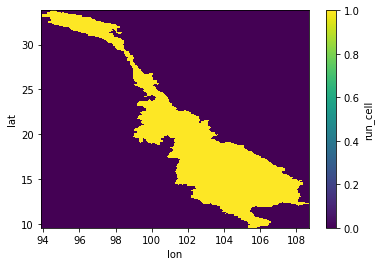

In [36]:
param_ds.run_cell.plot()

In [37]:
# param_ds.to_netcdf("../backend/params/vic/params.nc")
param_ds.to_netcdf("../extras/vic_using_metsim_try3/params_all_mekong.nc")